In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter, defaultdict
import os

In [2]:
file_path = './train_dataset_recurrent.csv' # './train_dataset_nonrecurrent.csv'
df = pd.read_csv(file_path)
print("sample num : %d | patient num : %d" %(len(df), len(df['Patient_ID'].value_counts())))
print(df.shape)
df.sample(5)

sample num : 206 | patient num : 48
(206, 19)


,Slide_name,Patient_ID,Recurrence,Location,Diagnosis,Growth phase,Size of tumor,Depth of invasion,Level of invasion,Mitosis,Histologic subtype,Tumor cell type,Surgical margin,Lymph node,Breslow thickness,Precursor lesion,Date_of_diagnosis,Date_of_recurrence,recurrence_period
100,train_789,train_pid_194,1,plantar,"MALIGNANT MELANOMA, INVASIVE",vertical,7.5 x 5.5 x 0.9 cm,8 mm,invasion into the subcutaneous fat (level 5),16/10HPF,acral lentiginous,epithelioid,"free from tumor (safety margin: anterior, 0.1 ...",cannot be assessed,NaN,NaN,2015-02-05,2015-05-13,97
87,train_776,train_pid_191,1,big toe,"MALIGNANT MELANOMA, invasive",radial,1.2 x 0.6 x 0.1cm,1mm,invasion to papillary dermis (level III),2/10 HPF,acral lentiginous,epithelioid,"free from tumor (safety margin: proximal, 0.2c...",cannot be assessed,NaN,NaN,2012-06-27,2022-11-29,3807
166,train_855,train_pid_206,1,thumb,"MALIGNANT MELANOMA, INVASIVE",vertical,1.6 x 0.9 x 0.5 cm,5 mm,invasion into the subcutaneous fat (level 5),20/10 HPF,acral lentiginous,epithelioid and spindle,"free from tumor (safety margin: proximal, 1.2 cm)",no metastatis in two lymph nodes,NaN,NaN,2017-01-19,2018-10-26,645
50,train_739,train_pid_180,1,finger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-08-12,2014-08-19,2198
144,train_833,train_pid_201,1,foot,"MALIGNANT MELANOMA, INVASIVE",vertical,2.5 x 2.1 x 1.1 cm,11 mm,invasion into the subcutaneous fat (level 5),24/10HPF,acral lentiginous,spindle and epithelioid,"free from tumor (safety margin: anterior, 2.1 ...",cannot be assessed,NaN,NaN,2015-01-13,2016-02-24,407


<Axes: title={'center': 'patient ID count'}, xlabel='Patient_ID', ylabel='count'>

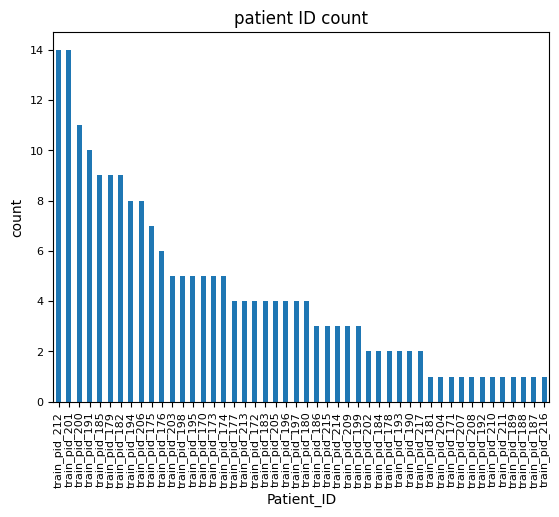

In [3]:
# df['Patient_ID'].value_counts()
df['Patient_ID'].value_counts().plot(kind="bar", title="patient ID count", ylabel='count', fontsize=8)

In [4]:
df['psudo_label'] = df.Location.map({c: idx for idx, c in enumerate(df.Location.unique())})
# df.sample(20)
df.shape

(206, 20)

In [5]:
print(df['Location'].value_counts())
print()
print(df['psudo_label'].value_counts())
print()

# ankle only in nonrecurrent (9)
# foor dorsum only in recurrent (1)

Location
foot           39
big toe        35
finger         32
sole           30
toe            24
heel           16
thumb          14
plantar         8
palm            6
hand            1
foot dorsum     1
Name: count, dtype: int64

psudo_label
4     39
1     35
3     32
7     30
2     24
5     16
0     14
9      8
6      6
8      1
10     1
Name: count, dtype: int64



In [6]:
X = df
Y = df.psudo_label.values # df['Location'].values
groups = np.array(df['Patient_ID'].values)

In [7]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    # print(np.max(y_vals))
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [8]:
fold_root = f"./{file_path.split('_')[-1][:-4]}_split_train_val"
print(file_path)
print(fold_root)

./train_dataset_recurrent.csv
./recurrent_split_train_val


In [18]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

distrs = [get_distribution(Y)]
index = ['training set']
cv = StratifiedGroupKFold(n_splits=5) # shuffle=True

for fold_ind, (dev_ind, val_ind) in enumerate(cv.split(X, Y, groups)):
    # print('# ', fold_ind, (dev_ind, val_ind))
    dev_x, val_x = X.iloc[dev_ind], X.iloc[val_ind]
    dev_y, val_y = Y[dev_ind], Y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    print(type(dev_x), type(val_x))
    print(type(dev_y), type(val_y))
    print(type(dev_groups), type(val_groups))
    
    # making sure that train and validation group do not overlap:
    assert len(set(dev_groups) & set(val_groups)) == 0
    print(f'# train : {len(dev_groups)} ({len(dev_groups)/len(groups):.2f}) | val : {len(val_groups)} ({len(val_groups)/len(groups):.2f})')
    # print('## ', len(set(dev_groups)), len(set(val_groups)))
    
    print(f"Fold {fold_ind}:")
    # print(f"  Train: index={dev_ind}")
    # print(f"         group={groups[dev_ind]}")
    # print(f"  Test:  index={val_ind}")
    # print(f"         group={groups[val_ind]}")
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')
    
    # dev_x.to_csv(os.path.join(fold_root, f"fold_{fold_ind}_train.csv"), index=False)
    # val_x.to_csv(os.path.join(fold_root, f"fold_{fold_ind}_val.csv"), index=False)

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(Y) + 1)])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
# train : 159 (0.77) | val : 47 (0.23)
Fold 0:
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
# train : 163 (0.79) | val : 43 (0.21)
Fold 1:
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
# train : 166 (0.81) | val : 40 (0.19)
Fold 2:
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
# train : 167 (0.81) | val : 39 (0.19)
Fold 3:
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/opt/conda/envs/torch-maic2023/lib/python3.9/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7,Label 8,Label 9,Label 10
training set,6.80%,16.99%,11.65%,15.53%,18.93%,7.77%,2.91%,14.56%,0.49%,3.88%,0.49%
development set - fold 0,3.77%,18.87%,11.95%,16.35%,21.38%,7.55%,3.77%,10.06%,0.63%,5.03%,0.63%
validation set - fold 0,17.02%,10.64%,10.64%,12.77%,10.64%,8.51%,0.00%,29.79%,None,None,None
development set - fold 1,5.52%,17.79%,11.66%,16.56%,17.18%,9.20%,3.68%,17.18%,0.61%,0.00%,0.61%
validation set - fold 1,11.63%,13.95%,11.63%,11.63%,25.58%,2.33%,0.00%,4.65%,0.00%,18.60%,None
development set - fold 2,8.43%,15.06%,11.45%,16.27%,20.48%,8.43%,2.41%,12.65%,0.00%,4.82%,None
validation set - fold 2,0.00%,25.00%,12.50%,12.50%,12.50%,5.00%,5.00%,22.50%,2.50%,0.00%,2.50%
development set - fold 3,8.38%,15.57%,11.98%,13.77%,20.96%,5.99%,1.20%,16.17%,0.60%,4.79%,0.60%
validation set - fold 3,0.00%,23.08%,10.26%,23.08%,10.26%,15.38%,10.26%,7.69%,None,None,None
development set - fold 4,7.69%,17.75%,11.24%,14.79%,14.79%,7.69%,3.55%,16.57%,0.59%,4.73%,0.59%


In [33]:
# # row 생략 없이 출력
# pd.set_option('display.max_rows', None)
# # col 생략 없이 출력
# pd.set_option('display.max_columns', None)

# import numpy as np
# from sklearn.model_selection import StratifiedGroupKFold

# # set the ratios for train, validation, and test splits
# train_ratio = 0.6 # 0.5
# val_ratio = 0.2 # 0.1
# test_ratio = 0.2 # 0.4

# assert train_ratio >= 0.5, "This code only works when train_ratio is the biggest"

# num_splits = int(1 / (val_ratio + test_ratio)) # 5

# X = df
# Y = df.psudo_label.values # df['Location'].values
# groups = np.array(df['Patient_ID'].values)

# distrs = [get_distribution(Y)]
# index = ['training set']

# num_folds = 3
# count_fold = 0
# for num_fold in range(num_folds):
#     # We instantiate a new one every time since we control the number of folds ourselves
#     sgkf = StratifiedGroupKFold(n_splits=num_splits, random_state=num_fold, shuffle=True)
#     # print(num_fold, num_splits)
#     for fold_idx, (train_indices, val_test_indices) in enumerate(sgkf.split(X, Y, groups)):
#         # print(type(train_indices), type(val_test_indices))
#         # print(train_indices, val_test_indices)
#         print(f"num_fold : {num_fold} | fold_idx : {fold_idx}")
#         X_train = X.iloc[train_indices] # X[train_indices]
#         Y_train = Y[train_indices]
#         groups_train = groups[train_indices]

#         X_val_test = X.iloc[val_test_indices] # X[val_test_indices]
#         Y_val_test = Y[val_test_indices]
#         groups_val_test = groups[val_test_indices]

#         # Now we have to split it based on the ratio between test and val
#         split_ratio = test_ratio / val_ratio
#         test_val_order = True
#         if split_ratio < 1: # In this case we invert the ratio and the assignment of test-val / val-test
#             test_val_order = False
#             split_ratio = 1 / split_ratio

#         split_ratio = int(split_ratio) + 1
#         print("val/test split_ratio : ", split_ratio)
#         sgkf2 = StratifiedGroupKFold(n_splits=split_ratio)
#         i1, i2 = next(sgkf2.split(X_val_test, Y_val_test, groups_val_test))
#         # print(i1, i2)
#         if test_val_order:
#             test_indices = i1
#             val_indices = i2
#         else:
#             test_indices = i2
#             val_indices = i1

#         X_val = X_val_test.iloc[val_indices] # X_val_test[val_indices]
#         Y_val = Y_val_test[val_indices]
#         groups_val = groups_val_test[val_indices]

#         X_test = X_val_test.iloc[test_indices] # X_val_test[test_indices]
#         Y_test = Y_val_test[test_indices]
#         groups_test = groups_val_test[test_indices]

#         # print("train groups = ", np.unique(groups_train))
#         # print("val groups = ", np.unique(groups_val))
#         # print("test groups = ", np.unique(groups_test))
#         # print(X_train.shape, X_val.shape, X_test.shape)
#         print(f"train : {X_train.shape} | val : {X_val.shape} | test : {X_test.shape}")
#         print(f" -> train : {len(X_train)/len(X):.2f} | val : {len(X_val)/len(X):.2f} | test : {len(X_test)/len(X):.2f}")
        
#         distrs.append(get_distribution(Y_train))
#         index.append(f'development set - fold {count_fold}')
#         distrs.append(get_distribution(Y_val))
#         index.append(f'validation set - fold {count_fold}')
#         distrs.append(get_distribution(Y_test))
#         index.append(f'test set - fold {count_fold}')
#         count_fold += 1

#     # print()

# display('Distribution per class:')
# pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(Y) + 1)])

num_fold : 0 | fold_idx : 0
val/test split_ratio :  2
train : (345, 20) | val : (171, 20) | test : (172, 20)
 -> train : 0.50 | val : 0.25 | test : 0.25
num_fold : 0 | fold_idx : 1
val/test split_ratio :  2
train : (343, 20) | val : (169, 20) | test : (176, 20)
 -> train : 0.50 | val : 0.25 | test : 0.26
num_fold : 1 | fold_idx : 0
val/test split_ratio :  2
train : (341, 20) | val : (173, 20) | test : (174, 20)
 -> train : 0.50 | val : 0.25 | test : 0.25
num_fold : 1 | fold_idx : 1
val/test split_ratio :  2
train : (347, 20) | val : (169, 20) | test : (172, 20)
 -> train : 0.50 | val : 0.25 | test : 0.25
num_fold : 2 | fold_idx : 0
val/test split_ratio :  2
train : (315, 20) | val : (186, 20) | test : (187, 20)
 -> train : 0.46 | val : 0.27 | test : 0.27
num_fold : 2 | fold_idx : 1
val/test split_ratio :  2
train : (373, 20) | val : (158, 20) | test : (157, 20)
 -> train : 0.54 | val : 0.23 | test : 0.23


/opt/conda/envs/torch-maic2023/lib/python3.9/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/opt/conda/envs/torch-maic2023/lib/python3.9/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7,Label 8,Label 9,Label 10
training set,12.65%,6.40%,10.03%,13.95%,25.00%,23.55%,4.51%,0.58%,0.87%,1.16%,1.31%
development set - fold 0,14.78%,6.38%,4.06%,12.46%,28.41%,24.93%,5.80%,0.58%,0.00%,0.00%,2.61%
validation set - fold 0,10.53%,6.43%,16.37%,15.79%,21.64%,22.22%,3.51%,0.58%,2.92%,None,None
test set - fold 0,10.47%,6.40%,15.70%,15.12%,21.51%,22.09%,2.91%,0.58%,0.58%,4.65%,None
development set - fold 1,10.50%,6.41%,16.03%,15.45%,21.57%,22.16%,3.21%,0.58%,1.75%,2.33%,None
validation set - fold 1,15.38%,6.51%,4.14%,13.02%,28.99%,25.44%,5.92%,0.59%,None,None,None
test set - fold 1,14.20%,6.25%,3.98%,11.93%,27.84%,24.43%,5.68%,0.57%,0.00%,0.00%,5.11%
development set - fold 2,15.25%,4.69%,6.45%,16.42%,24.34%,25.81%,4.69%,0.88%,1.47%,None,None
validation set - fold 2,10.40%,7.51%,13.87%,11.56%,25.43%,21.39%,4.62%,0.00%,0.00%,0.00%,5.20%
test set - fold 2,9.77%,8.62%,13.22%,11.49%,25.86%,21.26%,4.02%,0.57%,0.57%,4.60%,None
